In [ ]:
!unzip 'poetry.zip'

Archive:  poetry.zip
   creating: poetry/
  inflating: poetry/poetry_data_train — копия.json  
  inflating: __MACOSX/poetry/._poetry_data_train — копия.json  
  inflating: poetry/poetry_data_test — копия.json  
  inflating: __MACOSX/poetry/._poetry_data_test — копия.json  


In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder

from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
TEST_DATA_PATH = '/content/poetry/poetry_data_test — копия.json'
TRAIN_DATA_PATH = '/content/poetry/poetry_data_train — копия.json'

test_data = pd.read_json(TEST_DATA_PATH)
train_data = pd.read_json(TRAIN_DATA_PATH)

cpu


In [ ]:
14000/17000

0.8235294117647058

In [ ]:
train_data.shape, test_data.shape,

((138396, 5), (34599, 5))

In [ ]:
train_data.merge(test_data, how='inner', on=['output_text']).shape, train_data.merge(test_data, how='inner', on=['url']).shape

((0, 9), (0, 9))

In [ ]:
test_data.head()

,url,rating,views,output_text,genre
0,https://www.chitalnya.ru/work/2999707/,0,15,"Нынче головы четыре у дракона,\nПожиратель пре...",лирика
1,https://www.chitalnya.ru/work/1026761/,0,167,Сало Украине! Героям - Сало!\nЭтого продукта-д...,юмор
2,https://www.chitalnya.ru/work/2260544/,7,62,"Стая птиц летит по небосводу,\nЗа собою, в про...",лирика
3,https://www.chitalnya.ru/work/1889307/,9,132,"Холодно в дому, мысли как в сиропе,\nДаже свет...",лирика
4,https://www.chitalnya.ru/work/788355/,0,195,Иду я на вы!\nСвятослав говорил.\nЛежу я на вы...,юмор


## EDA

### text

<Axes: >

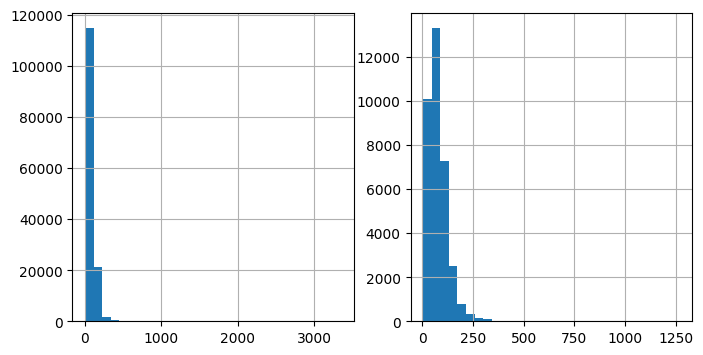

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
train_data.output_text.str.split().apply(len).hist(bins=30, ax=ax[0])
test_data.output_text.str.split().apply(len).hist(bins=30, ax=ax[1])

In [ ]:
train_data.output_text.str.split().apply(len).describe(percentiles=[.8, .9, .95])

,output_text
count,138396.000000
mean,78.676508
std,60.491816
min,4.000000
50%,70.000000
80%,109.000000
90%,136.000000
95%,165.000000
max,3353.000000


In [ ]:
test_data.output_text.str.split().apply(len).describe(percentiles=[.8, .9, .95])

,output_text
count,34599.000000
mean,78.513165
std,56.269884
min,5.000000
50%,70.000000
80%,110.000000
90%,137.000000
95%,166.000000
max,1269.000000


### target

<Axes: >

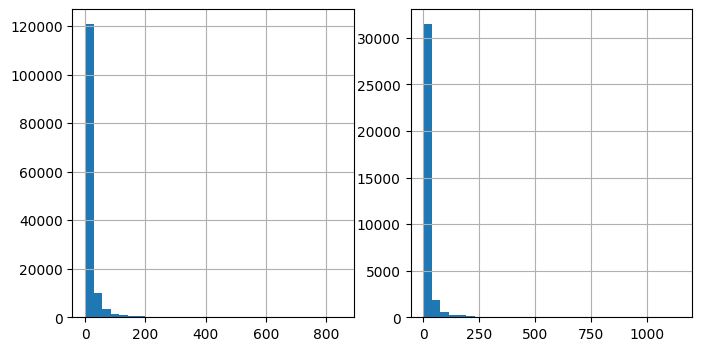

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
train_data.rating.hist(bins=30, ax=ax[0])
test_data.rating.hist(bins=30, ax=ax[1])

In [ ]:
train_data.rating.describe()

,rating
count,138396.000000
mean,11.920265
std,32.553441
min,0.000000
25%,0.000000
50%,0.000000
75%,8.000000
max,851.000000


In [ ]:
test_data.rating.describe()

,rating
count,34599.000000
mean,12.109310
std,33.551954
min,0.000000
25%,0.000000
50%,0.000000
75%,8.000000
max,1145.000000


In [ ]:
(train_data.rating > 0).value_counts(normalize=True)

,proportion
rating,
False,0.563492
True,0.436508


In [ ]:
(test_data.rating > 0).value_counts(normalize=True)

,proportion
rating,
False,0.559929
True,0.440071


### genre

In [ ]:
train_data.genre.nunique(), test_data.genre.nunique()

(35, 33)

In [ ]:
train_data.genre.value_counts(normalize=True)

,proportion
genre,
лирика,0.529531
юмор,0.211820
песни,0.074995
эротика,0.026005
Поэтические переводы,0.022327
акростихи,0.017269
стихи для детей,0.016460
басни,0.014126
Поэмы и циклы стихов,0.013180


In [ ]:
test_data.genre.value_counts(normalize=True)

,proportion
genre,
лирика,0.530420
юмор,0.212203
песни,0.074829
эротика,0.024538
Поэтические переводы,0.022399
акростихи,0.018035
стихи для детей,0.016070
басни,0.015347
Поэмы и циклы стихов,0.013613


### views

<Axes: >

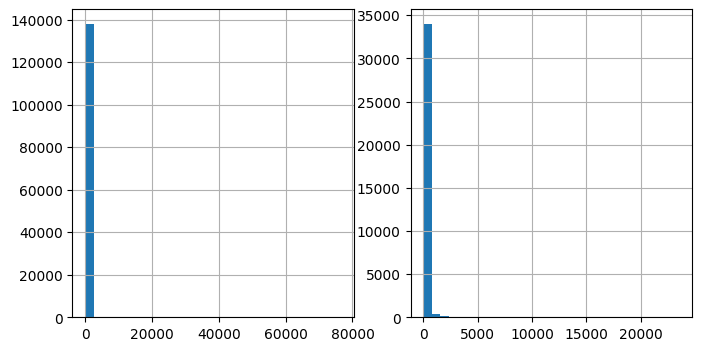

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
train_data.views.hist(bins=30, ax=ax[0])
test_data.views.hist(bins=30, ax=ax[1])

In [ ]:
train_data.views.describe()

,views
count,138396.000000
mean,132.442289
std,458.416320
min,10.000000
25%,22.000000
50%,51.000000
75%,135.000000
max,76680.000000


In [ ]:
test_data.views.describe()

,views
count,34599.00000
mean,130.92572
std,385.54511
min,10.00000
25%,22.00000
50%,51.00000
75%,133.00000
max,23568.00000


### dependencies

In [ ]:
def get_depend_plots(df):
  fig, ax = plt.subplots(2, 2, figsize=(30, 15))
  sns.scatterplot(x=df.views, y=df.genre, ax=ax[0, 1])
  plt.xticks(rotation=90)
  sns.scatterplot(x=df.rating, y=df.genre, ax=ax[0, 0])
  plt.xticks(rotation=90)
  sns.scatterplot(x=df.views, y=df.rating, ax=ax[1, 0])
  fig.show()

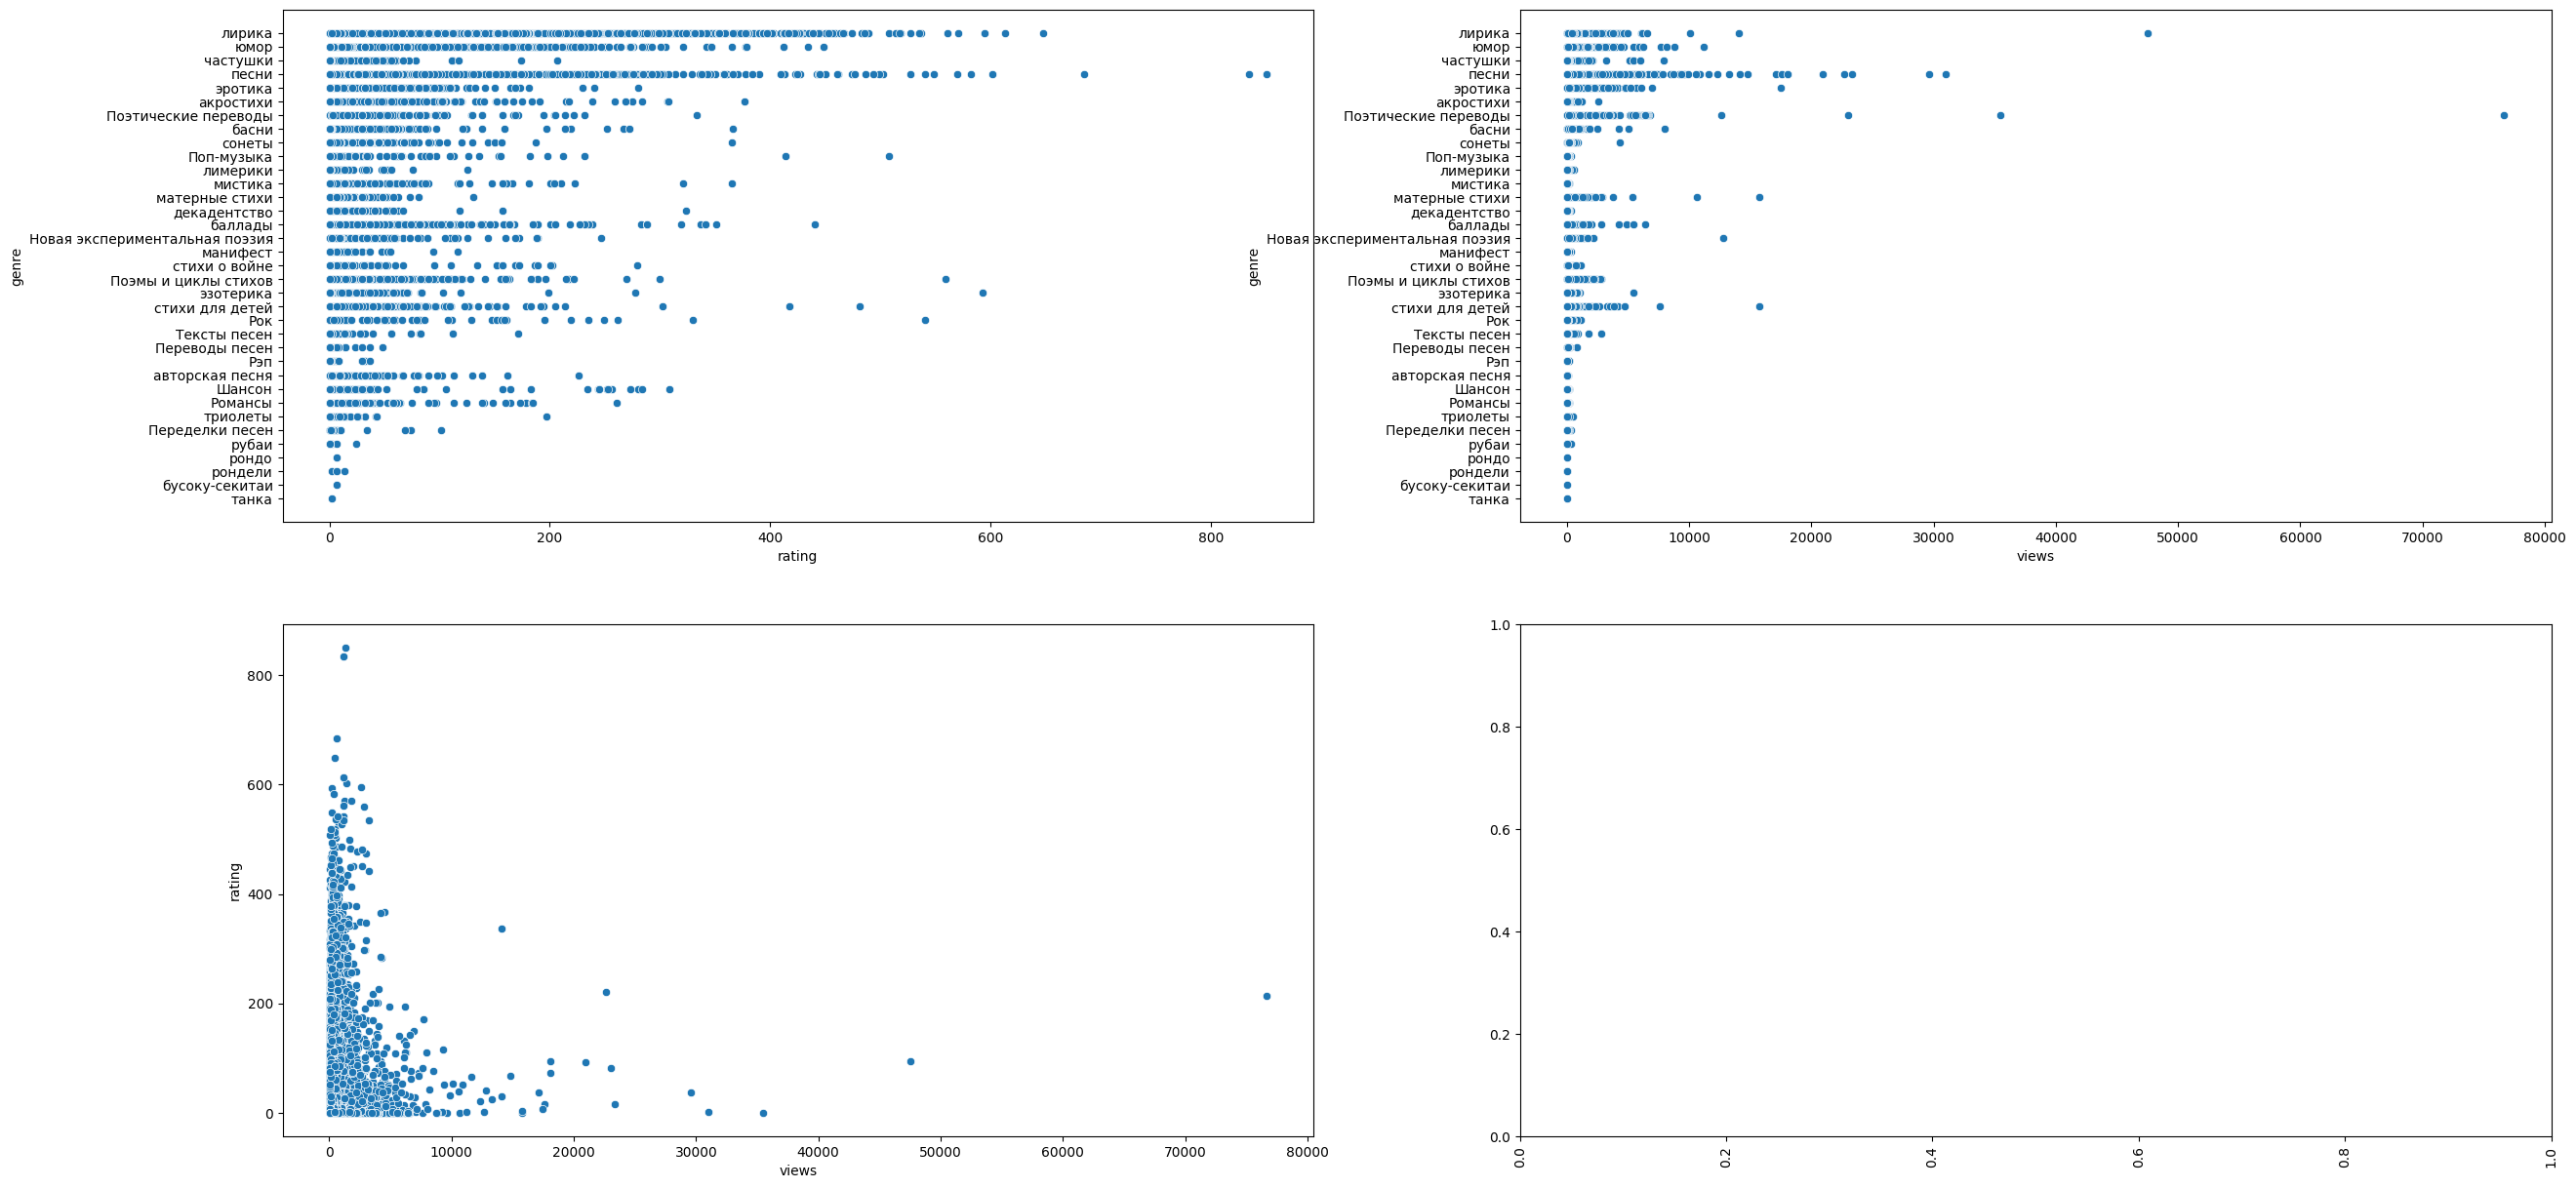

In [ ]:
get_depend_plots(train_data)

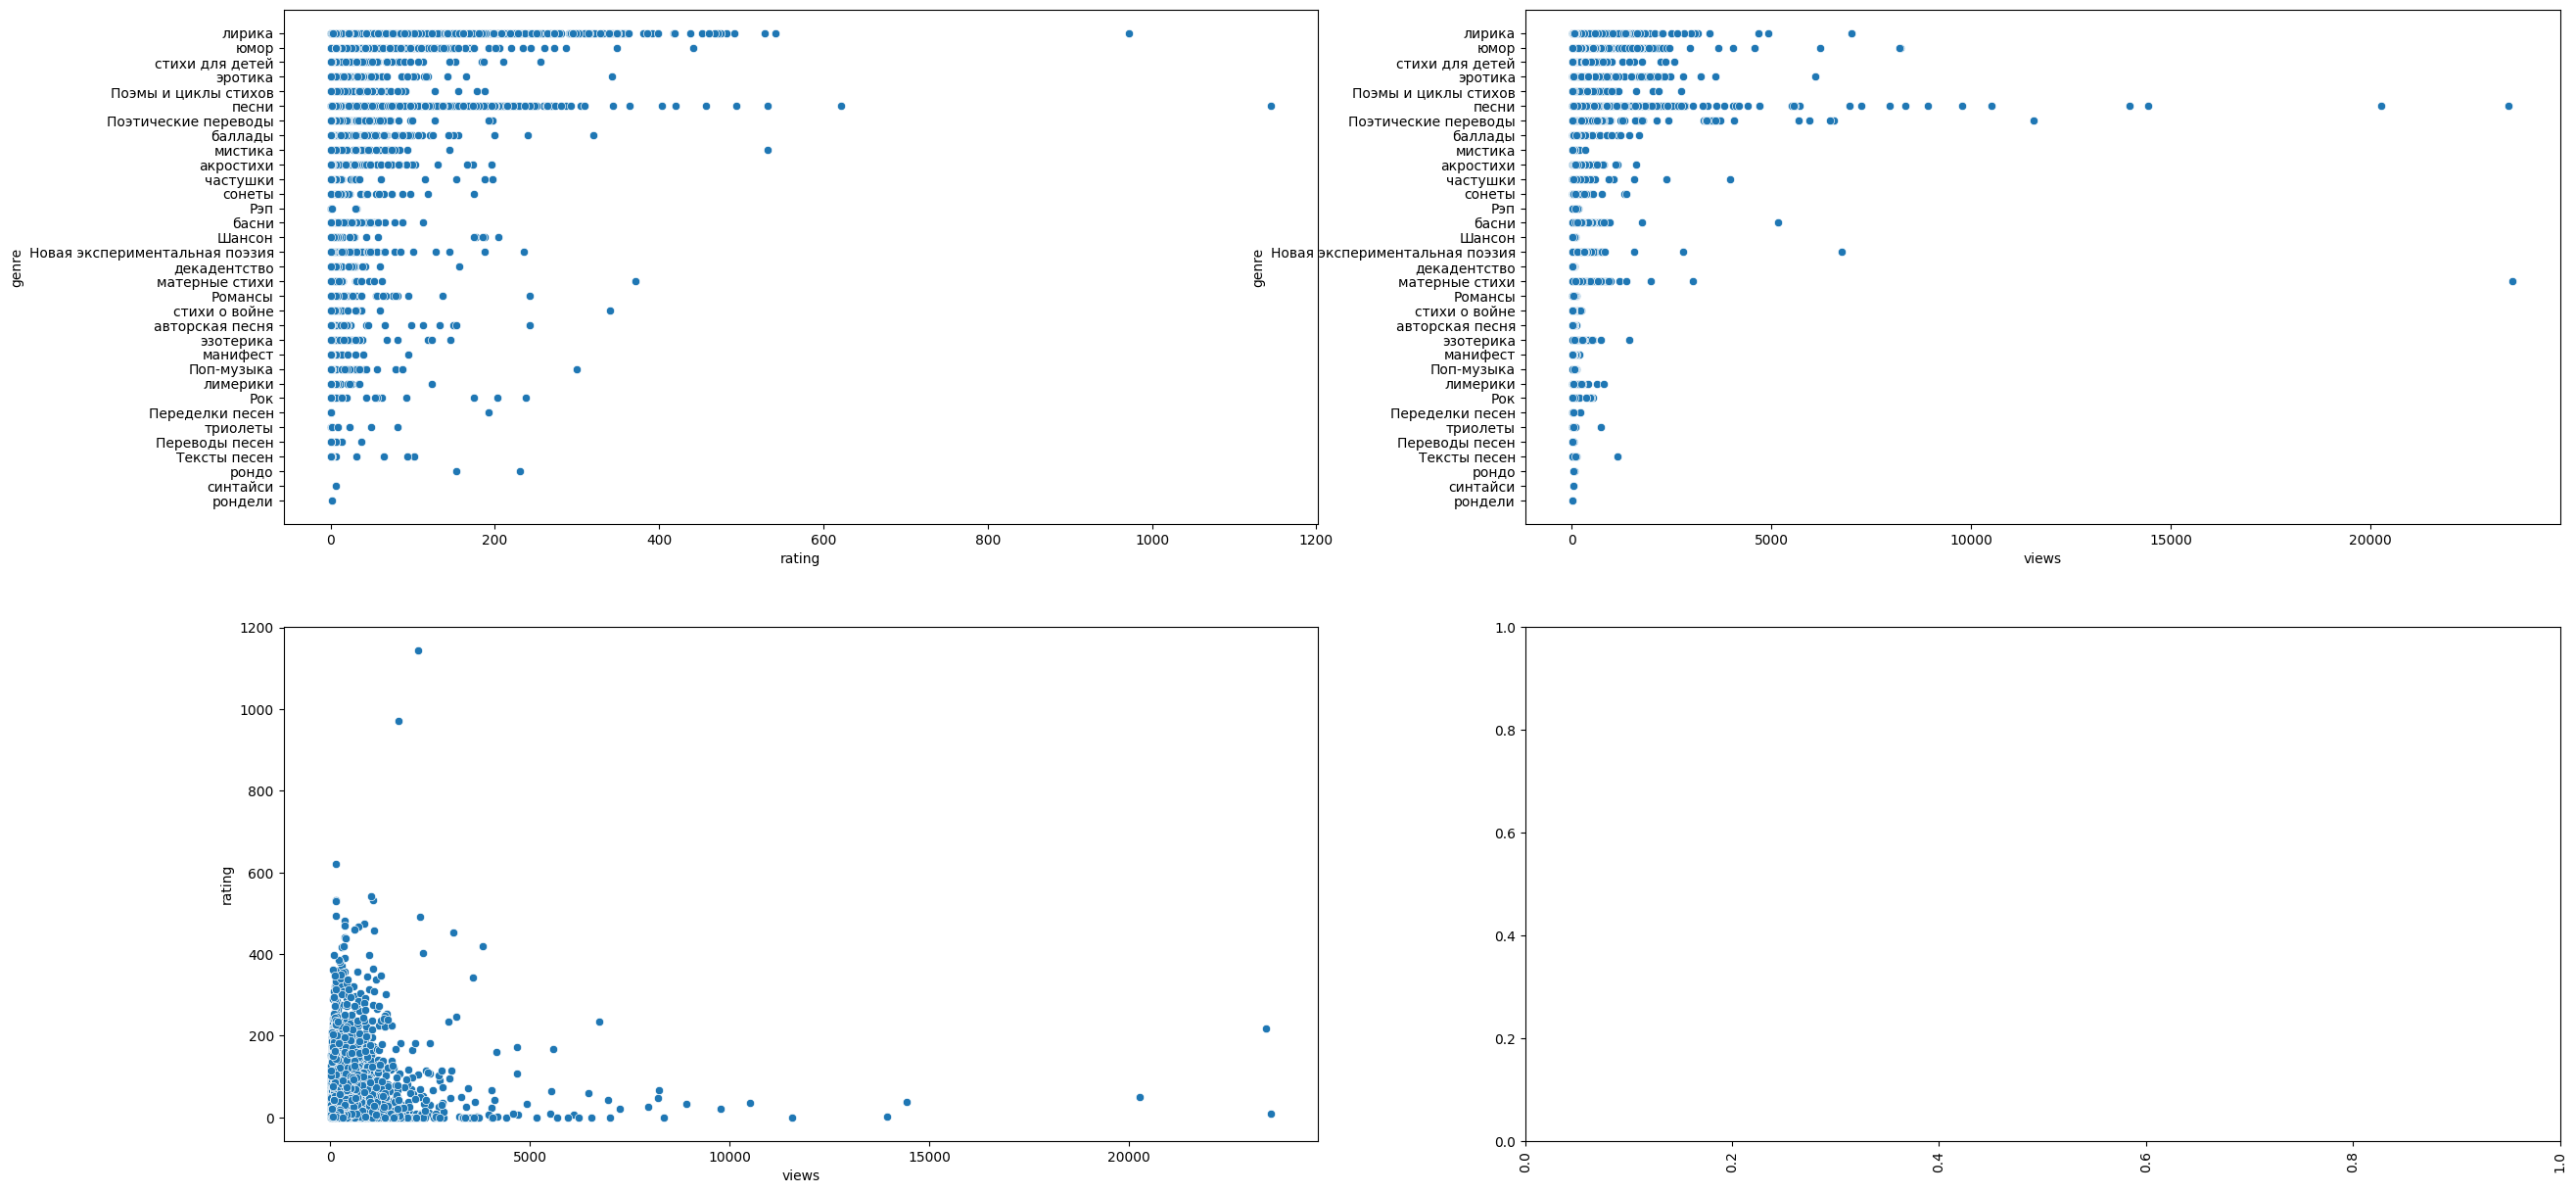

In [ ]:
get_depend_plots(test_data)

## Baseline

In [ ]:
# заменяем рейтинг на бинарную переменную 0/не0
# тексты - lower
# жанры - lower
# удаляем ссылки

def preprocess_data(df):
  df_mod = df.copy()
  df_mod.output_text = df_mod.output_text.str.lower()
  df_mod.rating = df_mod.rating.apply(lambda x: 1 if x > 0 else 0)

  return df_mod[['output_text', 'rating']]


train_data_mod = preprocess_data(train_data)
test_data_mod = preprocess_data(test_data)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data_mod.output_text)
X_test = vectorizer.transform(test_data_mod.output_text)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42).fit(X_train, train_data_mod.rating)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

roc_auc_score(test_data_mod.rating, clf.predict_proba(X_test)[:, 1]), accuracy_score(test_data_mod.rating, clf.predict(X_test))

(0.6518974744622479, 0.6201335298708055)

## BERT

In [ ]:
# заменяем рейтинг на бинарную переменную 0/не0
# для стихов может быть важно сохранить структуру (переносы строк), поэтому добавим новый токен для обозначения переносов строк + lower
# жанры приведем к нижнему регистру
# удаляем ссылки

NEWLINE_SPEC_TOKEN = '[NEWLINE]'

def preprocess_data(df):
  df_mod = df.copy()
  df_mod.output_text = df_mod.output_text.str.replace('\n', NEWLINE_SPEC_TOKEN)
  df_mod.output_text = df_mod.output_text.str.lower()
  df_mod.rating = df_mod.rating.apply(lambda x: 1 if x > 0 else 0)
  df_mod.genre = df_mod.genre.str.lower()
  df_mod = df_mod.drop('url', axis=1)

  return df_mod

train_data_mod = preprocess_data(train_data)
test_data_mod = preprocess_data(test_data)

# закондируем жанр через OneHotEncoder
# масштабируем просмотры через StandardScaler

ohe = OneHotEncoder()#.set_output(transform='pandas')
ohe.fit(train_data_mod.genre.to_frame())

scaler = StandardScaler()#.set_output(transform='pandas')
scaler.fit(train_data_mod.views.to_frame())

StandardScaler()

In [ ]:
# MODEL = 'DeepPavlov/rubert-base-cased'
MODEL = 'cointegrated/rubert-tiny2'

tokenizer = AutoTokenizer.from_pretrained(MODEL)
# добавляем новый токен для переноса строк
tokenizer.add_special_tokens({'additional_special_tokens': [NEWLINE_SPEC_TOKEN]})

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# выбираем макс длину последовательности
lst_len_tokens = []
for text in tqdm(train_data_mod.output_text.values):
  lst_len_tokens.append(len(tokenizer.encode(text, add_special_tokens=True)))

In [ ]:
pd.Series(lst_len_tokens).describe(percentiles=[.8, .9, .95])

In [ ]:
# берем макс длину по 95 перцентилю

# MAX_LENGTH = 306 # DeepPavlov
MAX_LENGTH = 414 #cointegrated

In [ ]:
class DatasetPoetry(Dataset):
    def __init__(self
                 , texts
                 , genres
                 , views
                 , labels
                 , tokenizer
                 , max_len
                 ):
        self.texts = texts
        self.genres = genres
        self.views = views
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        genre = self.genres[item]
        views = self.views[item]
        label = self.labels[item]
        model_inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': model_inputs['input_ids'].flatten(),
            'attention_mask': model_inputs['attention_mask'].flatten(),
            'genre': torch.tensor(genre, dtype=torch.long),
            'views': torch.tensor(views, dtype=torch.float),
            'labels': torch.tensor(label, dtype=torch.float).unsqueeze(0) # чтобы размеры labels и выходов модели совпадали
        }

In [ ]:
train_genre_ohe = ohe.transform(train_data_mod.genre.to_frame()).values
train_views_scaled = scaler.transform(train_data_mod.views.to_frame())
train_dataset = DatasetPoetry(
    train_data_mod.output_text.values
    , train_genre_ohe
    , train_views_scaled
    , train_data_mod.rating.values
    , tokenizer
    , MAX_LENGTH
)

test_genre_ohe = ohe.transform(test_data_mod.genre.to_frame()).values
test_views_scaled = scaler.transform(test_data_mod.views.to_frame())
test_dataset = DatasetPoetry(
    test_data_mod.output_text.values
    , test_genre_ohe
    , test_views_scaled
    , test_data_mod.rating.values
    , tokenizer
    , MAX_LENGTH
)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_genres):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.bert.resize_token_embeddings(len(tokenizer)) # добавляем новый токен для переноса строк
        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob)
        self.linear = nn.Linear(self.bert.config.hidden_size + num_genres + 1, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, input_ids, attention_mask, genres, views):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs[1]  # [CLS] token

        x = torch.cat((cls_output, genres, views), dim=1)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.sigmoid(x)

        return x

In [ ]:
def test_epoch(model, val_loader, criterion):
    lost_list = []
    model.eval()
    for data in tqdm(val_loader):
        input_ids = data['input_ids'].to(DEVICE)
        padding_mask = data['attention_mask'].to(DEVICE)
        genres = data['genre'].to(DEVICE)
        views = data['views'].to(DEVICE)
        labels = data['labels'].to(DEVICE)

        with torch.no_grad():
            outputs = model(input_ids, padding_mask, genres, views)
            loss = criterion(outputs, labels)
            lost_list.append(loss.item())

    return np.sum(lost_list)/len(val_loader)


def train_epoch(model, train_loader, optimizer, criterion):
    loss_list = []
    model.train()
    for data in tqdm(train_loader):
        input_ids = data['input_ids'].to(DEVICE)
        padding_mask = data['attention_mask'].to(DEVICE)
        genres = data['genre'].to(DEVICE)
        views = data['views'].to(DEVICE)
        labels = data['labels'].to(DEVICE)

        optimizer.zero_grad()
        outputs = model(input_ids, padding_mask, genres, views)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

    return np.sum(loss_list)/len(train_loader)


def train(model, train_loader, val_loader, optimizer, criterion, n_epochs):
    train_loss_list, val_loss_list = [], []
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion)
        val_loss = test_epoch(model, val_loader, criterion)

        print(f"Epoch {epoch}")
        print(f" train loss: {train_loss}")
        print(f" val loss: {val_loss}")

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

    plt.plot(train_loss_list, label='train')
    plt.plot(val_loss_list, label='val')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    return train_loss_list, val_loss_list

In [ ]:
print(DEVICE)
NUM_GENRES = ohe.get_feature_names_out().size


model = BERTClassifier(MODEL, NUM_GENRES)
model = model.to(DEVICE)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()
n_epochs = 10

train_dataloader = DataLoader(train_dataset, batch_size=40, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=40, shuffle=True)

train_loss_list, val_loss_list = train(model, train_dataloader, test_dataloader, optimizer, criterion, n_epochs)

cuda


100%|██████████| 865/865 [01:14<00:00, 11.63it/s]


Epoch 0
 train loss: 0.6444667505735607
 val loss: 0.6319210419076027


100%|██████████| 865/865 [01:16<00:00, 11.34it/s]


Epoch 1
 train loss: 0.5952976130853499
 val loss: 0.6419347168737753


100%|██████████| 865/865 [01:16<00:00, 11.34it/s]


Epoch 2
 train loss: 0.5044623963018029
 val loss: 0.7054122079314524


 31%|███       | 1069/3460 [04:09<09:17,  4.29it/s]


KeyboardInterrupt: 

In [ ]:
test_dataloader2 = DataLoader(test_dataset, batch_size=32, shuffle=False)
batch = next(iter(test_dataloader))

In [ ]:
lst = np.array([])
model.eval()
with torch.no_grad():
    for batch in tqdm(test_dataloader2):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        genre = batch['genre'].to(DEVICE)
        views = batch['views'].to(DEVICE)
        outputs = model(input_ids, attention_mask, genre, views)
        lst = np.concatenate((lst, outputs.squeeze().cpu().numpy()), axis=0)

100%|██████████| 1082/1082 [01:15<00:00, 14.43it/s]


In [ ]:
pd.Series((lst > 0.5).astype(int)).value_counts()

,count
0,21777
1,12822


In [ ]:
test_data_mod.rating.value_counts()

,count
rating,
0,19373
1,15226


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [ ]:
# 0.62, 0.6 = BERT + txt + genre + 3 epochs
roc_auc_score(test_data_mod.rating, lst), accuracy_score(test_data_mod.rating, (lst > 0.5).astype(int))

In [ ]:
# 0.6370916, 0.6068672 = BERT + txt + genre + views - 3 epochs
roc_auc_score(test_data_mod.rating, lst), accuracy_score(test_data_mod.rating, (lst > 0.5).astype(int))

(0.6370916529536176, 0.6068672504985694)